In [1]:
import shutil, os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5"
import matplotlib.pyplot as plt
import numpy as np
import detectron2
from detectron2.data import DatasetCatalog,MetadataCatalog
from plain_train_net import grab_dataset
import detectron2.utils.comm as comm
from detectron2.engine import launch



reprocess_results=True
# dataset_name = "reserves_fold1"
dataset_name = "val"
dpi=120

In [2]:
#predict
from detectron2.config import get_cfg
cfg = get_cfg()
cfg.merge_from_file('configs/working.yaml')
#really low iou for nms in order to separate out lesions
# cfg.merge_from_list(["MODEL.WEIGHTS", "output_valid_fold1/model_final.pth",
#                      "OUTPUT_DIR", "output_valid_"+ dataset_name + "/results"])
#print(cfg.dump())  # print formatted configs
print(cfg.MODEL.ROI_HEADS.dump())
print(cfg.MODEL.WEIGHTS)
print(cfg.OUTPUT_DIR)


BATCH_SIZE_PER_IMAGE: 512
IN_FEATURES:
- p2
- p3
- p4
- p5
IOU_LABELS:
- 0
- 1
IOU_THRESHOLDS:
- 0.5
NAME: StandardROIHeads
NMS_THRESH_TEST: 0.01
NUM_CLASSES: 1
POSITIVE_FRACTION: 0.25
PROPOSAL_APPEND_GT: true
SCORE_THRESH_TEST: 0.001

detectron2://ImageNetPretrained/FAIR/X-101-32x8d.pkl
./output


In [2]:
for name in [dataset_name]:
    try:
        DatasetCatalog.register(name, grab_dataset(name))
    except:
        print('Already registered.')
        #do nothing
    MetadataCatalog.get(name).thing_classes = ["rpd"]

# Prediction


In [5]:

#%%script false --no-raise-error
#os.environ["NCCL_DEBUG"] = "INFO"
#from torch.nn.parallel import DistributedDataParallel
from detectron2.modeling import build_model
from detectron2.data import build_detection_test_loader
from detectron2.checkpoint import DetectionCheckpointer
#from plain_train_net import EvaluateClass
from detectron2.evaluation import inference_on_dataset, COCOEvaluator

def predict_func(cfg,dataset_name):

    model = build_model(cfg)  # returns a torch.nn.Module
    # distributed = comm.get_world_size() > 1
    # if distributed:
    #     model = DistributedDataParallel(
    #         model, device_ids=[comm.get_local_rank()], broadcast_buffers=False
    #     )
    myloader = build_detection_test_loader(cfg,dataset_name)    
    myeval = COCOEvaluator(dataset_name,tasks={'bbox','segm'},output_dir ="output_"+ dataset_name) #produces _coco_format.json when initialized


    for mdl in ("fold1", "fold2", "fold3", "fold4","fold5"):
        #build model
        model_weights_path = "output_valid_"+ mdl +"/model_final.pth"
        DetectionCheckpointer(model).load(model_weights_path);  # load a file, usually from cfg.MODEL.WEIGHTS
        model.eval(); #set model in evaluation mode
        myeval.reset()
        output_dir = "output_"+ dataset_name + "/"+mdl
        myeval._output_dir = output_dir
        results_i = inference_on_dataset(model, myloader, myeval) #produces coco_instance_results.json when myeval.evaluate is called
    
    return

predict_func(cfg,dataset_name)
# launch(
#     predict_func,
#     6, # of gpus
#     num_machines=1,
#     machine_rank=0,
#     dist_url="auto",
#     args=(cfg,dataset_name,), #args to predict_func
# )

Using previously cached COCO format annotations at 'output_val/val_coco_format.json'. You need to clear the cache file if your dataset has been modified.


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.248
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.640
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.115
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.249
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.105
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.391
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.405
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.405
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50

# Ensembling

In [6]:
#%%script false --no-raise-error
from Ensembler import Ensembler
ens = Ensembler('output_'+dataset_name,dataset_name,["fold1", "fold2", "fold3", "fold4","fold5"],.2)
ens.mean_score_nms()
ens.save_coco_instances()

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.11s)
creating index...
index created!
Successfully loaded output_val/fold1/coco_instances_results.json into memory. 7392 instance detected.

Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Successfully loaded output_val/fold2/coco_instances_results.json into memory. 7219 instance detected.

Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Successfully loaded output_val/fold3/coco_instances_results.json into memory. 6868 instance detected.

Loading and preparing results...
DONE (t=0.11s)
creating index...
index created!
Successfully loaded output_val/fold4/coco_instances_results.json into memory. 7251 instance detected.

Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Successfully loaded output_val/fold5/coco_instances_results.json into memory. 7074 instance detected

# Evaluation

## Ensemble

Using previously cached COCO format annotations at 'output_val/val_coco_format.json'. You need to clear the cache file if your dataset has been modified.


loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.22s)
creating index...
index created!
Calculated metrics for 931 images
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.29s).
Accumulating evaluation results...
DONE (t=0.01s).
{'dataset': 'val', 'precision': 0.5032659409020218, 'recall': 0.8300000000000001, 'fpr': 0.32057416267942584, 'iou': 0.2, 'probability': 0.5}


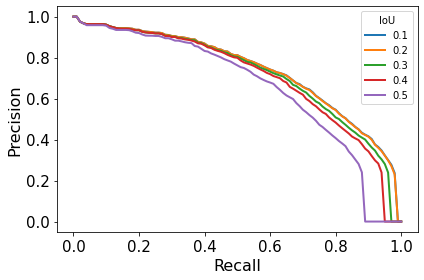

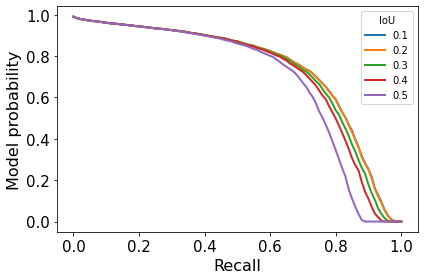

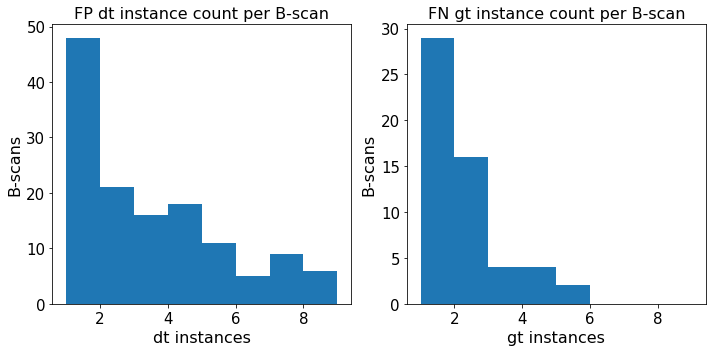

In [3]:
from plain_train_net import EvaluateClass,CreatePlotsRPD
import json
#evaluate ensemble
myeval = EvaluateClass(
    dataset_name, "output_"+ dataset_name,iou_thresh = .2,prob_thresh=0.5,evalsuper=False)
myeval.evaluate()
%precision 3
print(myeval.summarize_scalars())
with open(os.path.join("output_"+ dataset_name,'scalar_dict.json'),"w") as outfile:
    json.dump(obj=myeval.summarize_scalars(),fp=outfile)
num_images = myeval.num_images
myeval.plot_PRcurve()
plt.tight_layout()
myeval.plot_recall_vs_prob()
plt.tight_layout()

RPDplt = CreatePlotsRPD.initfromcoco(myeval.mycoco,myeval.prob_thresh)
RPDplt.gt_dt_FP_FN_count();


## Individual Models

In [9]:
#evaluate individual models
import json
myeval.evalsuper=False
for mdl in ("fold1", "fold2", "fold3", "fold4","fold5"):
    myeval.reset()
    output_dir = "output_"+ dataset_name + "/"+mdl
    myeval._output_dir = output_dir
    myeval.evaluate()
    print(myeval.summarize_scalars())
    with open(os.path.join(output_dir,'scalar_dict.json'),"w") as outfile:
        json.dump(obj=myeval.summarize_scalars(),fp=outfile)


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Calculated metrics for 931 images
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.37s).
Accumulating evaluation results...
DONE (t=0.01s).
{'dataset': 'val', 'precision': 0.5265213146762122, 'recall': 0.8300000000000001, 'fpr': 0.32057416267942584, 'iou': 0.2, 'probability': 0.5}
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Calculated metrics for 931 images
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.24s).
Accumulating evaluation results...
DONE (t=0.01s).
{'dataset': 'val', 'precision': 0.5163505559189012, 'recall': 0.81, 'fpr': 0.3014354066985646, 'iou': 0.2, 'probability': 0.5}
loading annotations into memory...
Done (t=0.01s)
creating index...
index

In [10]:
import json, os
import pandas as pd
from table_styles import styles
mydicts=[]
for mdl in ['fold1','fold2','fold3','fold4','fold5']:
    output_dir = "output_"+ dataset_name + "/"+mdl
    with open(os.path.join(output_dir,'scalar_dict.json')) as f:
        mydicts.append(json.load(f))
with open(os.path.join("output_"+ dataset_name,'scalar_dict.json')) as f:
    mydicts.append(json.load(f))
dfr = pd.DataFrame(mydicts)
dfr = dfr.assign(fp = np.int32(dfr.fpr*num_images))
dfr = dfr.assign(model = ['1','2','3','4','5','ensemble'])
#dfr = dfr[['model','fpr','fp','probability','dataset']]
pd.set_option('display.precision',3)
dfr.style.set_table_styles(styles).set_table_attributes('style="font-size: 17px"')

,dataset,precision,recall,fpr,iou,probability,fp,model
0,val,0.527,0.830,0.321,0.200,0.500,298,1
1,val,0.516,0.810,0.301,0.200,0.500,280,2
2,val,0.545,0.810,0.301,0.200,0.500,280,3
3,val,0.512,0.800,0.285,0.200,0.500,265,4
4,val,0.499,0.830,0.321,0.200,0.500,298,5
5,val,0.503,0.830,0.321,0.200,0.500,298,ensemble


gt_instances   gt_pxs  gt_xpxs  dt_instances    dt_pxs  dt_xpxs
ptid   eye                                                                 
101135 OD          278.0  69404.0  11034.0         359.0   99059.0  15690.0
       OS          295.0  69302.0  10858.0         421.0  107739.0  17500.0
101243 OD            8.0   1425.0    241.0          91.0   24535.0   3926.0
       OS           60.0  13824.0   2250.0         204.0   53651.0   9050.0
101273 OD          200.0  40978.0   6119.0         441.0  101948.0  16934.0
       OS          262.0  53680.0   7817.0         396.0   78184.0  12541.0
101308 OD           96.0  14217.0   1874.0         277.0   50506.0   8818.0
       OS           71.0  10271.0   1559.0         181.0   30012.0   5332.0
101338 OD           17.0   3325.0    645.0         148.0   35057.0   6467.0
       OS           59.0  13172.0   2283.0         188.0   50341.0   9258.0
102020 OD          184.0  32957.0   5326.0         142.0   27485.0   4187.0
       OS          161.0  26395.0   3786.0         174.0   27896.0   4121.0
104033 OD            2.0    437.0     55.0           0.0       0.0      0.0
       OS            4.0    716.0    104.0           3.0     461.0     71.0
104047 OD           64.0   9387.0   1348.0          88.0   13652.0   2305.0
501006 OD           33.0   6643.0   1036.0          29.0    7835.0   1235.0
       OS           15.0   3722.0    527.0          16.0    2987.0    414.0
501010 OD           74.0  12240.0   1479.0          35.0    6477.0    753.0
       OS           66.0  10037.0   1218.0          30.0    5040.0    571.0

# Visualize Output

In [4]:
from plain_train_net import OutputVis

pred_file = "output_"+ dataset_name + "/coco_instances_results.json"
out_file = os.path.join("output_"+ dataset_name,'mean_score_nms_'+dataset_name+'.pdf')

# mdl = 'fold1'
# pred_file = os.path.join("output_"+ dataset_name,mdl,"coco_instances_results.json")
# out_file = os.path.join("output_"+ dataset_name,'mean_score_nms_'+mdl+'.pdf')

# vis = OutputVis(dataset_name,prob_thresh = 0.5,pred_mode='file',pred_file=pred_file,has_annotations=False)
# ImgIds = RPDplt.dfimg.index[RPDplt.dfimg.dt_instances>0] #np.abs(df.gt_xpxs-df.dt_xpxs).sort_values(ascending=False).index[0:50].values
# vis.output_to_pdf(ImgIds,out_file)

df = RPDplt.dfimg
vis = OutputVis(dataset_name,prob_thresh = 0.5,pred_mode='file',pred_file=pred_file,has_annotations=True)
ImgIds = np.abs(df.gt_xpxs-df.dt_xpxs).sort_values(ascending=False).index[0:1].values
vis.output_to_pdf(ImgIds,out_file)


100%|██████████| 10/10 [00:22<00:00,  2.23s/it]


In [33]:
import pandas as pd
from table_styles import styles
df = pd.read_csv('/data/amd-data/cera-rpd/cera-rpd-train/data_RPDHimeesh_drusen_reserves/dffolds.csv').set_index('ptid')
grp = df.groupby('fold')
grp2 = df.reset_index().groupby('fold')
grp3 = df.reset_index().groupby(['fold','ptid','eye']).size().groupby('fold')
dfsummary = pd.concat([grp2[['scan','ptid']].nunique(),grp3.size().to_frame('eye'),grp.sum()],axis=1)
dfsummary

dfsummary.style.set_table_styles(styles).set_table_attributes('style="font-size: 17px"')

,scan,ptid,eye,yellow,white,red,black
fold,,,,,,,
fold1,1078,11,22,0.000000,0.000000,0.000000,547520512.000000
fold2,1176,12,24,0.000000,0.000000,0.000000,597295104.000000
fold3,1274,13,26,0.000000,0.000000,0.000000,647069696.000000
